In [1]:
import os
import pandas as pd
from twitterED.utilities.utils import text_cleaning, tokenizer,encoding_data,get_length
from twitterED.network.model import BERT
from torch.utils.data import TensorDataset ,DataLoader
import torch
from tqdm.notebook import tqdm
import numpy as np
from twitterED.utilities.prediction import predict, labels

In [2]:
df_infr = pd.read_csv('data.csv',header=0)
df_infr.head()

,Tweet ID,Username,Tweet,Date of tweet,Time of tweet,Tweet_type,Location
0,1312541672916615168,🥇Warrior Network💪,Losing fat is probably simplistic whilst integ...,2020-10-03,23:54:55,Tweet,"Bournemouth, England"
1,1312541345484017665,Jim,@realDonaldTrump First China virus now Plague ...,2020-10-03,23:53:37,Tweet,"Weymouth, England"
2,1312540747346972672,Peter Lamb,@Oh_So_Blunt @miffythegamer But look at the st...,2020-10-03,23:51:14,Tweet,Dorset UK
3,1312538678783213569,gabriel,"RT @TBroomey: The mournful tone, the uncharact...",2020-10-03,23:43:01,ReTweet,"Joinville, Brasil"
4,1312538070181310465,🥇Warrior Network💪,I want to uncover my fortune suggestions; retu...,2020-10-03,23:40:36,Tweet,"Bournemouth, England"


In [3]:
#cleaning text
# fixing contarctions
df_infr['Tweet']= df_infr['Tweet'].apply(text_cleaning.fix_contractions)
# remove accent characters
df_infr['Tweet']= df_infr['Tweet'].apply(text_cleaning.remove_accented_chars)
# remove digits
df_infr['Tweet']= df_infr['Tweet'].apply(text_cleaning.remove_digits)
#remove excess withe spaces
df_infr['Tweet']= df_infr['Tweet'].apply(text_cleaning.remove_excess_whitespace)
# remove punctuations except ?!
df_infr['Tweet']= df_infr['Tweet'].apply(text_cleaning.rm_punctuation1)
# teurn to lower case
df_infr['Tweet']= df_infr['Tweet'].apply(text_cleaning.lower)

In [4]:
max_len = max(df_infr['Tweet'].apply(get_length))
print (f'maximum length of tweet:{max_len}')

maximum length of tweet:53


In [5]:
infr_data = df_infr.Tweet.values
encoded_data_infer = encoding_data(infr_data, max_len = max_len)
#encoding process above returns dictionaries. We grab input ID tokens, attention mask, and labels from this
input_ids_infer = encoded_data_infer['input_ids'] #return each sentence as a #
attention_masks_infer = encoded_data_infer['attention_mask'] #returns a pytorch tensor

C:\Users\ehsan\.conda\envs\emodetection\lib\site-packages\transformers\tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [6]:
dataset_infr = TensorDataset(input_ids_infer, attention_masks_infer)
dataloader_infr = DataLoader(dataset_infr,batch_size=16)

In [7]:
label_dict = labels['botdtct']
model = BERT(label_dict=label_dict)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model_path = 'wieght/botdtc/Epoch-2.model'
model.load_state_dict(torch.load(model_path))

model.eval()
model.to(device)
pass

In [10]:
i2c = lambda i: [k for k,v in label_dict.items() if v ==i][0]
i2c(0)

'bot'

In [11]:
def predict(dataloader_infr, model, device, predictions=None):
    
    if predictions is None:
        predictions = []

    for batch in tqdm(dataloader_infr):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                 }
        #ignore/disable gradients
        with torch.no_grad():        
            outputs = model(**inputs)

        #loss = outputs[0]
        logits = outputs[0]
        #loss_val_total += loss.item()

        #detach from CPU means pulling values out of GPU to CPU
        #so we can use numpy
        logits = logits.detach().cpu().numpy()
        #label_ids = inputs['labels'].cpu().numpy()
        
        predictions.append(logits)
        
    predictions = np.concatenate(predictions, axis=0)
    preds_flat = np.argmax(predictions, axis=1).flatten()

        
    return preds_flat.tolist()

In [12]:
prediction = predict(dataloader_infr, model=model, device=device)

In [22]:
prediction

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
df_infr['acc_type']=prediction
df_infr['acc_type']=df_infr['acc_type'].apply(i2c)
df_infr.head()

,Unnamed: 0,Tweet ID,Username,Tweet,Date of tweet,Time of tweet,Tweet_Type,Location,Set 1(fully cleaned),Pred_int,account,acc_type
0,0,1307816586410100000,_____811_______,rt ah yes the public who failed care homes ...,20/09/2020,23:59:06,ReTweet,"Birmingham, England",ye public fail care home support cum durham tr...,0,personal,human
1,1,1307816458462850000,DeuxLeopardsdor,rt is it possible that dido harding and her ...,20/09/2020,23:58:36,ReTweet,Europe,dido hard husband john penros nh overwhelm pus...,0,personal,human
2,2,1307816022834110000,MsKinLondon,rt ah yes the public who failed care homes ...,20/09/2020,23:56:52,ReTweet,NaN,ye public fail care home support cum durham tr...,0,personal,human
3,3,1307815890730330000,carne_sean,rt ah yes the public who failed care homes ...,20/09/2020,23:56:21,ReTweet,Laaaandan,ye public fail care home support cum durham tr...,0,personal,human
4,4,1307815521312800000,OllyMursgirl42,well i was homeless at then in my 20s with ze...,20/09/2020,23:54:52,Tweet,"Bournemouth, England",homeless zero live hardship children mental he...,0,personal,human


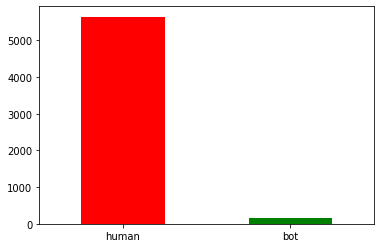

In [14]:
ax =df_infr['acc_type'].value_counts().plot.bar(x='lab', y='val', rot=0,color = list('rgbkymc'))